In [1]:
import matplotlib.pyplot as plt
import torch 
import os
import networkx as nx
import torch_geometric as tg

In [75]:
# check the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import the dataset 
dataset_cora = tg.datasets.Planetoid('/Users/gaurav/Desktop/research/gnn_udemy/cora_dataset', "Cora")
data_cora = dataset_cora[0]
print('cora: ', data_cora)


cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [76]:
print('number of nodes:', data_cora.num_nodes)
print('number of edges:', data_cora.num_edges)
print('edge index:', data_cora.edge_index)
print('number of features:', data_cora.num_features)
print('number of wghts per edge:', data_cora.num_edge_features)
print('edge wghts:', data_cora.edge_weight)
print('number of classes: ', dataset_cora.num_classes)

number of nodes: 2708
number of edges: 10556
edge index: tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
number of features: 1433
number of wghts per edge: 0
edge wghts: None
number of classes:  7


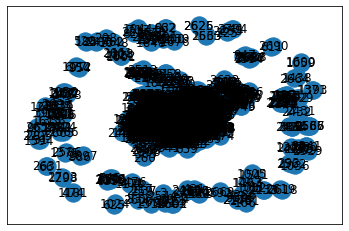

In [83]:
G = tg.utils.convert.to_networkx(data_cora)
nx.draw_networkx(G, pos=nx.spring_layout(G))
plt.show()

In [8]:
# import the dataset 
dataset_kc = tg.datasets.KarateClub()
data_kc = dataset_kc[0]
print('Kc: ', data_kc)
print(data_kc.y)

Kc:  Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


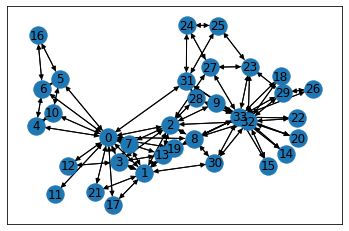

In [5]:
G = tg.utils.convert.to_networkx(data_kc)
nx.draw_networkx(G)
plt.show()

In [84]:
# import the dataset 
dataset_shapenet = tg.datasets.ShapeNet('/Users/gaurav/Desktop/research/gnn_udemy/shapenet_dataset', "Car")
data_shapenet = dataset_shapenet[0]
print('shapenet: ', data_shapenet)

print(' ======================  ')
print('number of nodes:', data_shapenet.num_nodes)
print('number of edges:', data_shapenet.num_edges)
print('edge index:', data_shapenet.edge_index)
print('number of features:', data_shapenet.num_features)
print('number of wghts per edge:', data_shapenet.num_edge_features)
print('edge wghts:', data_shapenet.edge_weight)
print(dataset_shapenet.num_classes)

shapenet:  Data(x=[2882, 3], y=[2882], pos=[2882, 3], category=[1])
number of nodes: 2882
number of edges: 0
edge index: None
number of features: 3
number of wghts per edge: 0
edge wghts: None
50


In [85]:
# Let's use Cora dataset to build a GCN model

# construct the GCN model for the classification task
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(GCN, self).__init__()
        self.gcn1 = tg.nn.GCNConv(in_channels, hidden_channels, cached=True,)
        self.gcn2 = tg.nn.GCNConv(hidden_channels, out_channels, cached=True,)
        self.dropout = torch.nn.Dropout(0.3)
        self.relu = torch.nn.ReLu()
        
    def forward(self, x, edge_index, edge_weight):
        x = self.relu(self.gcn1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = self.gcn2(x, edge_index, edge_weight)

        return torch.nn.functional.log_softmax(x)


In [78]:
# define the model
in_channels = data_cora.num_features # could be edge index, edge wght, or num_features
out_channels = dataset_cora.num_classes  # output labels
hidden_channels = 512
model = GCN(in_channels, out_channels, hidden_channels).to(device)

# sending data to device
data_cora = data_cora.to(device)

# loss and optimizer 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


In [86]:
# training 
def train():
    model.train()
    optimizer.zero_grad()
    output = model(data_cora.x, data_cora.edge_index, data_cora.edge_weight)
    
    loss = criterion(output[data_cora.train_mask], data_cora.y[data_cora.train_mask])  # we calculate loss only for training
    loss.backward()
    optimizer.step()
    return float(loss)

In [87]:
# testing 
def test():
    model.eval()
    with torch.no_grad():
        pred = model(data_cora.x, data_cora.edge_index, data_cora.edge_weight).argmax(dim=-1)

        accs = []
        for mask in [data_cora.train_mask, data_cora.val_mask, data_cora.test_mask]:
            accs.append(int((pred[mask] == data_cora.y[mask]).sum()) / int(mask.sum()))
        return accs
        
best_val_acc = final_test_acc = 0
for epoch in range(5):
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch={epoch} \t Loss={loss} \t Train={train_acc} \t Val={val_acc} \t Test={test_acc}')

Epoch=0 	 Loss=0.8041365742683411 	 Train=0.9785714285714285 	 Val=0.772 	 Test=0.787
Epoch=1 	 Loss=0.750053346157074 	 Train=0.9785714285714285 	 Val=0.78 	 Test=0.79
Epoch=2 	 Loss=0.6800826191902161 	 Train=0.9857142857142858 	 Val=0.784 	 Test=0.792
Epoch=3 	 Loss=0.6037355065345764 	 Train=0.9857142857142858 	 Val=0.782 	 Test=0.792
Epoch=4 	 Loss=0.5452300310134888 	 Train=0.9857142857142858 	 Val=0.79 	 Test=0.802


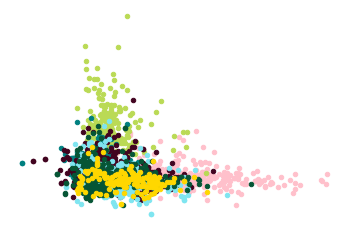

In [82]:
@torch.no_grad()
def plot_point(colors):
    model.eval() # Evaluate the model based on the trained parameters
    z = model(data_cora.x, data_cora.edge_index, data_cora.edge_weight) # Embedding rep
#     z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data_cora.y.cpu().numpy()
    plt.figure()
    for i in range(dataset_cora.num_classes):
        plt.scatter(z[y==i,0],z[y==i,1],s=20,color=colors[i])
    plt.axis('off')
    plt.show()
colors = [
        '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
        '#ffd700'
    ]
plot_point(colors)